# Importing the data

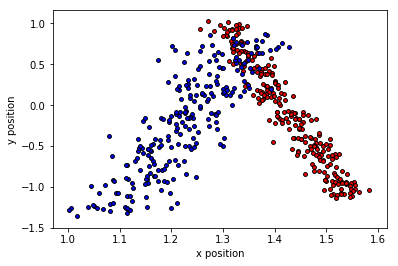

In [109]:
from pandas import read_csv   #Let's us read in the comma-separated text file
import matplotlib.pyplot as plt  #Our go-to module for plotting

data = read_csv('data.csv')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(data['red_pos_X'], data['red_pos_Y'] , color = 'red', edgecolors = 'black', s = 15)
ax.scatter(data['blue_pos_X'], data['blue_pos_Y'] , color = 'blue', edgecolors = 'black', s =15)
ax.set_xlabel('x position')
ax.set_ylabel('y position')

plt.show()

# a) Posterior distributions of speed

Looking ahead to part (c), let's describe our velocities using (speed, angle) notation rather than (v_x, v_y).  (This will make equating the speeds easier.)  That is, for a given object, its position  will be described by $x(t) = x_0 + (v\cos\theta)t$ and $y(t) = y_0 + (v\sin\theta)t$.

We have to choose some prior distributions for our model, but we don't really know much about these moving objects.  I'll take the velocities to be 'normally' distributed about 0; the priors for speed will be PyMC3's HalfNormal distribution, <s>and the priors for the angle will be a Uniform distribution around the full circle.</s> Evidently uniform priors are not the best thing to use, and the sampling runs quickly with Normal/HalfNormal distributions, so everything will be given a (Half)Normal distribution with a sufficiently large standard deviation. See https://docs.pymc.io/api/distributions/continuous.html for a list of available continuous distributions.

### Setting up the model

In [122]:
import pymc3 as pm  #Our main 'hammer' according to the Bayesian Methods for Hackers notebook
import numpy as np  #Grab some trig functions 

def modelData(data, samespeed): 
    """This function takes the array of .csv data, along with a boolean value indicating
    whether or not the blue/red speeds are to be fixed equal to each other.  All variables
    in the model are given (Half)Normal distributions, and the model is then run using the
    NUTS sampling algorithm.  The function then returns the trace."""
    with pm.Model() as model:
        #HalfNormal distributions keep these distributions positive
        v_r = pm.HalfNormal('v_r', sd = 0.1)
        if samespeed == True:
            v_b = v_r  #blue and red speeds are the same
        else:
            v_b = pm.HalfNormal('v_b', sd = 0.1)

        sigma = pm.HalfNormal('sigma', sd = 1.0)

        #Normal distributions make the NUTS algorithm run more smoothly
        theta_r = pm.Normal('theta_r', mu = 0, sd = 1.0)
        theta_b = pm.Normal('theta_b', mu = 0, sd = 1.0)
        x0_r = pm.Normal('x0_r', mu = 0, sd = 1.0)
        y0_r = pm.Normal('y0_r', mu = 0, sd = 1.0)
        x0_b = pm.Normal('x0_b', mu = 0, sd = 1.0)   
        y0_b = pm.Normal('y0_b', mu = 0, sd = 1.0)


        #The expected (x,y) values for the red and blue objects
        x_r_expected = x0_r + v_r*np.cos(theta_r)*data['t']
        y_r_expected = y0_r + v_r*np.sin(theta_r)*data['t']
        x_b_expected = x0_b + v_b*np.cos(theta_b)*data['t']
        y_b_expected = y0_b + v_b*np.sin(theta_b)*data['t']

        #Likelihood distributions for the normally-distributed (x,y) positions
        x_r = pm.Normal('x_r_likelihood', mu = x_r_expected, sd = sigma, observed = (data['red_pos_X']))
        y_r = pm.Normal('y_r_likelihood', mu = y_r_expected, sd = sigma, observed = (data['red_pos_Y']))
        x_b = pm.Normal('x_b_likelihood', mu = x_b_expected, sd = sigma, observed = (data['blue_pos_X']))
        y_b = pm.Normal('y_b_likelihood', mu = y_b_expected, sd = sigma, observed = (data['blue_pos_Y']))
    
    #Running the NUTS algorithm
    with model:
        step = pm.NUTS()
        trace = pm.sample(10000, step = step, njobs = 4)
        
    return trace

### Saving/Loading results

Thanks to [this post](https://stackoverflow.com/questions/44764932/can-a-pymc3-trace-be-loaded-and-values-accessed-without-the-original-model-in-me), the traces from NUTS can be saved and retrieved later using Pickle.

In [74]:
import pickle

def saveTrace(model, trace, filename):
    with open(filename, 'wb') as buff:
        pickle.dump({'model': model, 'trace': trace}, buff)

def openTrace(filename):
    with open(filename, 'rb') as buff:
        temp_data = pickle.load(buff)  

    return temp_data['trace']

### Example in running the model
First get the trace:

In [123]:
trace = modelData(data, True)  #all of the data, the objects are assumed to be moving at the same speed

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y0_b, x0_b, y0_r, x0_r, theta_b, theta_r, sigma_log__, v_r_log__]
The acceptance probability does not match the target. It is 0.895400714613, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890944099234, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.900973630623, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885040436037, but should be close to 0.8. Try to increase the number of tuning steps.


Then save it with the appropriate file name:

In [125]:
saveTrace(model, trace, 'sameV_alldata.pkl')

The other three cases, are as follows (the above case is for part c):

In [ ]:
trace2 = modelData(data, False)
saveTrace(model, trace2, 'diffV_alldata.pkl')

trace3 = modelData(data[:100], True)
saveTrace(model, trace3, 'sameV_100data.pkl')

trace4 = modelData(data[:100], False)
saveTrace(model, trace4, 'diffV_100data.pkl')

To save time, we can then load them all later

In [117]:
trace = openTrace('sameV_alldata.pkl')
trace2 = openTrace('diffV_alldata.pkl')
trace3 = openTrace('sameV_100data.pkl')
trace4 = openTrace('diffV_100data.pkl')

If we want to look at the results of the sampling algorithm,

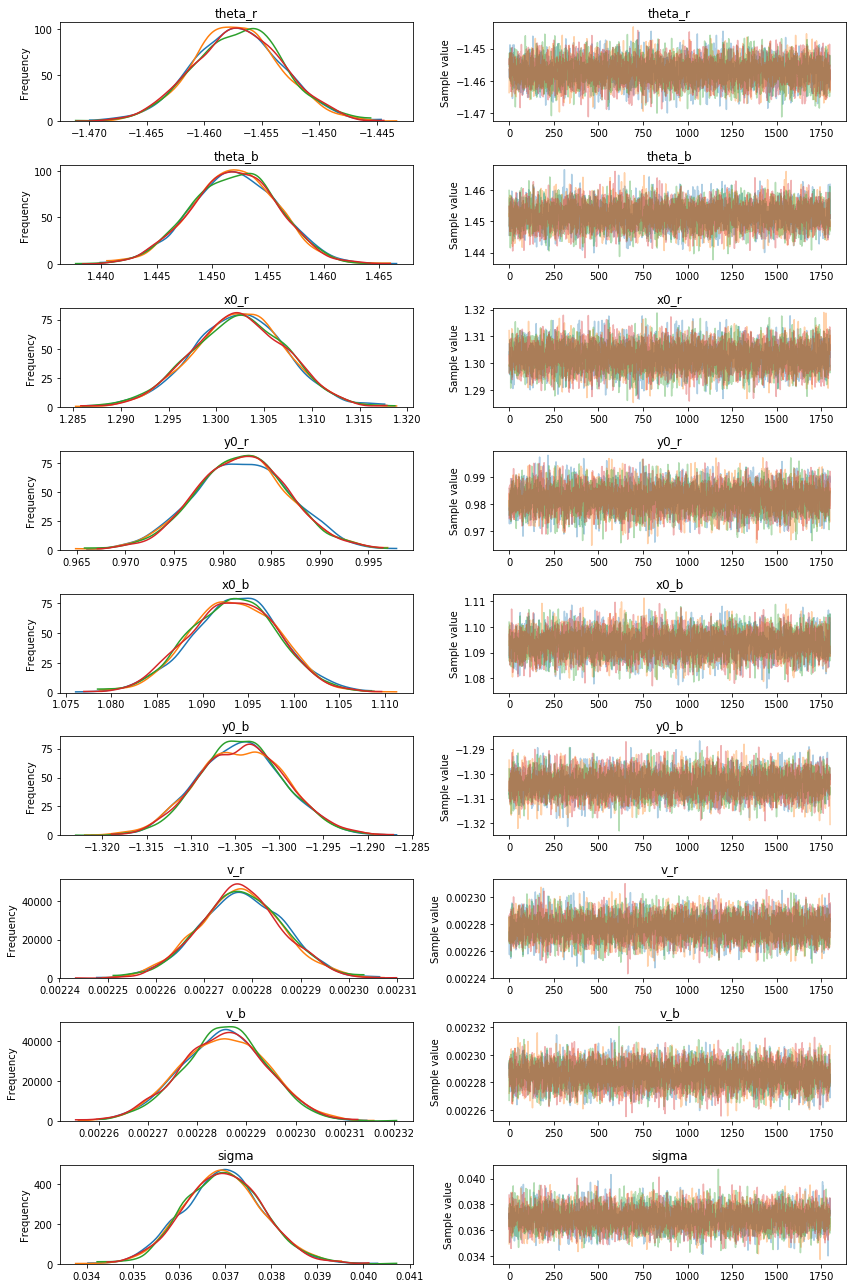

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta_r,-1.457051,0.003870,1.870439e-05,-1.464507,-1.449301,40000.0,0.999977
theta_b,1.452029,0.003852,1.831567e-05,1.444545,1.459547,40000.0,1.000003
x0_r,1.302268,0.004930,2.436151e-05,1.292698,1.312015,40000.0,0.999972
y0_r,0.981863,0.004841,2.086751e-05,0.972396,0.991298,40000.0,0.999985
x0_b,1.093488,0.004884,2.227566e-05,1.083914,1.103037,40000.0,0.999984
y0_b,-1.304245,0.004882,2.494861e-05,-1.313740,-1.294544,40000.0,1.000061
v_r,0.002277,0.000009,4.037385e-08,0.002260,0.002294,40000.0,1.000025
v_b,0.002285,0.000009,4.272854e-08,0.002268,0.002303,40000.0,1.000048
sigma,0.036951,0.000854,3.272773e-06,0.035320,0.038672,40000.0,0.999979


In [230]:
pm.traceplot(trace2[1000:][::5]);  #burn first 1000 steps and 'prune' the result by taking every 5th step
plt.show()
pm.summary(trace2)

### Plotting the posterior distributions for speed

In [228]:
def plotPosterior(trace):
    bin_width = 1e-6
    """This function takes a trace and plots the distribution of red/blue speeds
    as a histogram.  If the speeds were taken to be equal, just the red speed is 
    plotted (this is handled by excepting a KeyError for the missing 'v_b' value)."""
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))  #scientific notation on x-axis
    ax.set_xlabel('speed')
    ax.set_ylabel('frequency')
    v_r = trace['v_r'][1000:][::5]  #rembember to 'burn and prune' the results
    try:
        v_b = trace['v_b'][1000:][::5]
        mu = "{:.3E}".format(np.mean(v_b))
        sigma = "{:.3E}".format(np.sqrt(np.var(v_b)))
        ax.hist(v_b, color='blue', alpha = 0.4, bins=np.arange(min(v_b), max(v_b) + bin_width, bin_width), label = f'$\mu$, $\sigma$ = {mu}, {sigma}')
    except KeyError:  
        pass
    mu = "{:.3E}".format(np.mean(v_r))
    sigma = "{:.3E}".format(np.sqrt(np.var(v_r)))
    ax.hist(v_r, color='red', alpha = 0.4, bins=np.arange(min(v_r), max(v_r) + bin_width, bin_width), label = f'$\mu$, $\sigma$ = {mu}, {sigma}')
    plt.legend(loc='upper left')
    
    plt.show()

For example, using the above function, we plot our answer to part (a).  As the filename used to save/load 'trace2' suggests, the full data set was used and the speeds were assumed to be different.

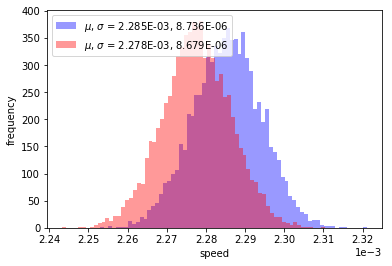

In [231]:
plotPosterior(trace2)

# b) Confidence interval

These posterior distributions can be converted to distributions for the 'zero-crossing' time $t_0$ by solving $y(t_0) = 0$.  This gives $t_0 = -\frac{y_0}{v\sin\theta}$.

In [232]:
def plotCrossingTimes(trace):
    """This function takes a trace and plots the distribution of the 'zero-crossing time'
    for each object.  If the speeds were taken to be equal, the 'v_b' distribution is set 
    equal to the 'v_r' distribution (this is handled by excepting a KeyError for the missing 'v_b' value)."""
    v_r = trace['v_r'][1000:][::5]
    y0_r = trace['y0_r'][1000:][::5]
    theta_r = trace['theta_r'][1000:][::5]
    
    try:
        v_b = trace['v_b'][1000:][::5]
    except KeyError:
        v_b = trace['v_r'][1000:][::5]
    y0_b = trace['y0_b'][1000:][::5]
    theta_b = trace['theta_b'][1000:][::5]

    #Solving for the crossing times
    t0_r = -y0_r/v_r/np.sin(theta_r)
    t0_b = -y0_b/v_b/np.sin(theta_b)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('time (crossing y = 0)')
    ax.set_ylabel('frequency')
    ax.hist(t0_r, color='red', alpha = 1.0)
    ax.hist(t0_b, color='blue', alpha = 1.0)
    
    plt.show()

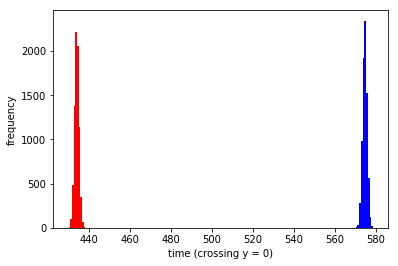

In [238]:
plotCrossingTimes(trace2)

As you can see, the blue object crosses $y = 0$ at a much later time than the red object.  The Y value of the blue object is  < 0 for times left of the blue curve.  So, we are justified in using the distribution of 'crossing' times for the blue object to find our 90% confidence interval.

In [239]:
def findConfidenceInterval(trace):
    '''This function takes a trace and finds a 90% confidence interval for
    the time at which both objects have crossed Y = 0.  It does this two ways:
    (1) fitting a Gaussian to the blue distribution and using the common +/- 1.645
    standard deviations from the mean (2) using the np.percentile() function directly
    on the distribution.  If the speeds were taken to be equal, the 'v_b' distribution is set 
    equal to the 'v_r' distribution (this is handled by excepting a KeyError for the missing 'v_b' value).'''
    try:
        v_b = trace['v_b'][1000:][::5]
    except KeyError:
        v_b = trace['v_r'][1000:][::5]
    y0_b = trace['y0_b'][1000:][::5]
    theta_b = trace['theta_b'][1000:][::5]

    t0_b = -y0_b/v_b/np.sin(theta_b)
    
    mean = np.mean(t0_b)
    sigma = np.sqrt(np.var(t0_b))  
    print('The (5%, 95%) confidence interval is')
    print('%.3f, %.3f by fitting a Gaussian' % (mean - 1.645*sigma, mean + 1.645*sigma))
    print('%.3f, %.3f using np.percentile()' % (np.percentile(t0_b, 5), np.percentile(t0_b, 95)))
    
    

In [240]:
findConfidenceInterval(trace2)

The (5%, 95%) confidence interval is
572.910, 576.563 by fitting a Gaussian
572.909, 576.558 using np.percentile()


# c) Same speed

Repeating everything is now straightforward; make sure the traces have either been generated or loaded.

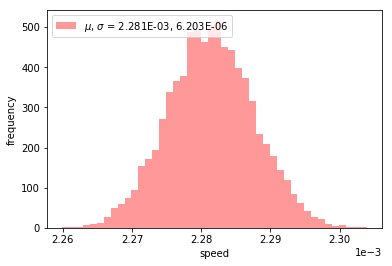

The (5%, 95%) confidence interval is
573.096, 576.659 by fitting a Gaussian
573.100, 576.641 using np.percentile()


In [243]:
plotPosterior(trace)
findConfidenceInterval(trace)

# d) Repeat with smaller N

### Different speeds

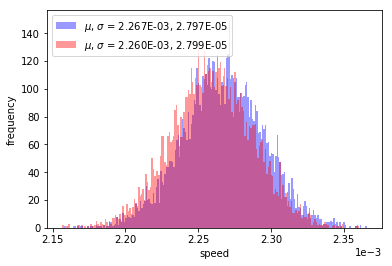

The (5%, 95%) confidence interval is
570.126, 586.016 by fitting a Gaussian
570.148, 586.064 using np.percentile()


In [244]:
plotPosterior(trace4)
findConfidenceInterval(trace4)

### Same speed

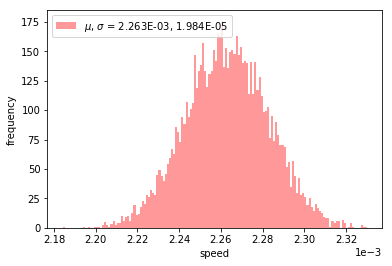

The (5%, 95%) confidence interval is
572.698, 584.738 by fitting a Gaussian
572.621, 584.762 using np.percentile()


In [245]:
plotPosterior(trace3)
findConfidenceInterval(trace3)

As you'd expect, the confidence intervals became a bit larger with smaller $N$.  In Bayesian language, we'd say that we are less certain in the time at which both objects have crossed Y=0.  This makes sense with a smaller data set.  Note also that the $\sigma$ associated with our posterior speed distributions has more than doubled, so we are also less certain in the speeds of the objects.

# Summarizing everything

Let's first modify our plotting function to allow the part (c) speed distributions to be plotted on the same histogram as the 'different speed' distributions.  The 'same speed' distribution will be plotted in green.

In [256]:
def plotOverlayedPosterior(trace, trace2):
    bin_width = 1e-6
    """This function takes a trace and plots the distribution of red/blue speeds
    as a histogram.  If the speeds were taken to be equal, just the red speed is 
    plotted (this is handled by excepting a KeyError for the missing 'v_b' value).
    It then takes a second trace (where the speeds are the same) and also plots its
    speed distribution in green"""
    fig = plt.figure(figsize = (7,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))  #scientific notation on x-axis
    ax.set_xlabel('speed')
    ax.set_ylabel('frequency')
    v_r = trace['v_r'][1000:][::5]  #rembember to 'burn and prune' the results
    v_same = trace2['v_r'][1000:][::5]  #rembember to 'burn and prune' the results
    try:
        v_b = trace['v_b'][1000:][::5]
        mu = "{:.3E}".format(np.mean(v_b))
        sigma = "{:.3E}".format(np.sqrt(np.var(v_b)))
        ax.hist(v_b, color='blue', alpha = 0.4, bins=np.arange(min(v_b), max(v_b) + bin_width, bin_width), label = f'$\mu$, $\sigma$ = {mu}, {sigma}')
    except KeyError:  
        pass
    mu = "{:.3E}".format(np.mean(v_r))
    sigma = "{:.3E}".format(np.sqrt(np.var(v_r)))
    ax.hist(v_r, color='red', alpha = 0.4, bins=np.arange(min(v_r), max(v_r) + bin_width, bin_width), label = f'$\mu$, $\sigma$ = {mu}, {sigma}')
    mu = "{:.3E}".format(np.mean(v_same))
    sigma = "{:.3E}".format(np.sqrt(np.var(v_same)))
    ax.hist(v_same, color='green', alpha = 0.4, bins=np.arange(min(v_same), max(v_same) + bin_width, bin_width), label = f'$\mu$, $\sigma$ = {mu}, {sigma}')
    plt.legend(loc='upper left')
    
    plt.show()

### Using the full data set

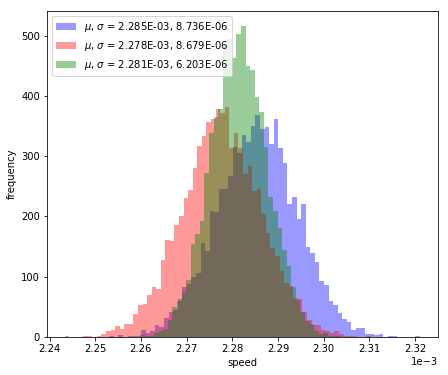

In [257]:
plotOverlayedPosterior(trace2,trace)

In [261]:
print('When the speeds have different distributions')
findConfidenceInterval(trace2)
print('\nWhen the speeds are taken to be equal')
findConfidenceInterval(trace)

When the speeds have different distributions
The (5%, 95%) confidence interval is
572.910, 576.563 by fitting a Gaussian
572.909, 576.558 using np.percentile()

When the speeds are taken to be equal
The (5%, 95%) confidence interval is
573.096, 576.659 by fitting a Gaussian
573.100, 576.641 using np.percentile()


### Using the first 100 measurements

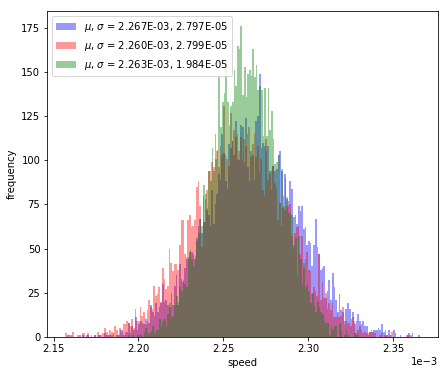

In [258]:
plotOverlayedPosterior(trace4,trace3)

In [262]:
print('When the speeds have different distributions')
findConfidenceInterval(trace4)
print('\nWhen the speeds are taken to be equal')
findConfidenceInterval(trace3)

When the speeds have different distributions
The (5%, 95%) confidence interval is
570.126, 586.016 by fitting a Gaussian
570.148, 586.064 using np.percentile()

When the speeds are taken to be equal
The (5%, 95%) confidence interval is
572.698, 584.738 by fitting a Gaussian
572.621, 584.762 using np.percentile()
